In [ ]:
import pyodbc
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime

# Baixando bases necessárias

Vamos aplicar esse caso para regiões de saúde, pois é o escopo dos modelos que testamos 

In [ ]:
host = '***'
port = ***
uid = '***'
pwd = '***'
driver = 'Dremio Connector'

cnxn = pyodbc.connect("Driver={};ConnectionType=Direct;HOST={};PORT={};AuthenticationType=Plain;UID={};PWD={}".format(driver, host,port,uid,pwd),autocommit=True)

sql = '''SELECT * FROM "Analytics Layer"."Epidemiológico"."Nascidos Vivos por Região de Saúde"
         WHERE substr(COD_REGSAUD, 1, 2) = '52' '''

df = pd.read_sql(sql,cnxn)
df.head()


In [69]:
cols = ['ano','mes']
df['ano_mes'] = df[cols].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)

df_t = df.drop(columns=['ano','mes'])

df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4859 entries, 0 to 4858
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uf_sigla      4859 non-null   object
 1   cod_regsaud   4859 non-null   object
 2   regiao_saude  4859 non-null   object
 3   quantidade    4859 non-null   int64 
 4   ano_mes       4859 non-null   object
dtypes: int64(1), object(4)
memory usage: 189.9+ KB


Vamos usar o API criada pelo Wanderson para verificar os procedimentos necessários para cada nascido vivo de um mês de referência e região de saúde

In [ ]:
dfs = [] 

for _, row in df_t.iterrows():
    qtd_nascidos = round(row['quantidade'])
    ano_mes = row['ano_mes']
    url = f'http://200.137.215.27:5025/calcula_procedimentos?mes_ano={ano_mes}&nascidos_vivos={qtd_nascidos}'
    print("Chamando", url)
    resultado = requests.get(url)
    df_it = pd.DataFrame(resultado.json())
    df_it['ano_mes'] = row['ano_mes'] 
    df_it['qtd_nascidos'] = qtd_nascidos
    df_it['regiao'] = row['cod_regsaud']
    dfs.append(df_it)
    df_full = pd.concat(dfs, ignore_index=True)

In [ ]:
df_full.head()
#df.to_csv("total_procedimentos_PBI.csv")

**Descrição de variáveis** 
- codigo_sigtap: código de identificação única de um procedimento (um procedimento pode ocorrer múltiplas vezes ao longo da gestação, como o pré-natal)
- mes: mês de referência que aquele procedimento deve ser realizado (mês 1 = primeiro mês de gestação)
- parametro: quantos procedimentos naquele mês para o total de gestantes devem ser realizados (ex.: existem procedimentos que só metade das gestantes precisam fazer) 
- procedimento: nome do procedimento
- tipo_procedimento: tipo de procedimento
- gestantes: tipo de gestante que realiza os procedimentos. Via de regra pode ser todas ou, para alguns procedimentos, as de alto risco
- nivel_atencao: nível de atenção onde aquele procedimento geralmente é realizado
- categoria_profissional_fim: a categoria profissional finalística que executa o procedimento. Existem categorias de apoio, mas estamos mapeando apenas a categoria fim 
- quantidade: quantidade de procedimentos que devem ser realizados tendo em vista as colunas parametro e qtd_nascidos
- mes_gestacao: mês da gestação que aquele procedimento deve ser realizado, tomando como referência as colunas ano_mes e mes
- qtd_nascidos: quantidade de registros de nascidos vivos para a região de saúde
- regiao: código IBGE que identifica a região de saúde

# Calculando procedimentos por mês 

Agora vamos calcular a quantidade de procedimentos por mês de realização do procedimento

In [60]:
procedimentos_mes = df_full.groupby(['regiao','ano_mes','mes_gestacao','qtd_nascidos',
                                     'codigo_sigtap'])['quantidade'].sum().reset_index()

In [61]:
procedimentos_mes[["mes_gestacao"]] = procedimentos_mes[["mes_gestacao"]].apply(pd.to_datetime) 
procedimentos_mes['codigo_sigtap'] = procedimentos_mes['codigo_sigtap'].astype('str') 

procedimentos_mes.head()

,regiao,ano_mes,mes_gestacao,qtd_nascidos,codigo_sigtap,quantidade
0,52001,2000-01,1999-05-01,2092,301010110,2092.0
1,52001,2000-01,1999-06-01,2092,202020355,2092.0
2,52001,2000-01,1999-06-01,2092,202020380,2092.0
3,52001,2000-01,1999-06-01,2092,202020479,1046.0
4,52001,2000-01,1999-06-01,2092,202030180,2092.0


Considerando o total de procedimentos, vamos computar em horas primeiro. Para isso, vamos ler uma planilha com estimativas de tempos dos procedimento. **Em uma implementação de sistema, é requisito que os tempos sejam ajustados pelo usuário.** 

In [62]:
tempos = pd.read_excel("procedimentos_tempos.xlsx") 
tempos['codigo_sigtap'] = tempos['codigo_sigtap'].astype('str')
tempos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   codigo_sigtap  37 non-null     object 
 1   procedimento   37 non-null     object 
 2   Tempo          37 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1016.0+ bytes


In [63]:
df_tempos = procedimentos_mes.merge(tempos, on = 'codigo_sigtap', how = 'left')

df_tempos['horasProfissionais'] = df_tempos['quantidade'] * df_tempos['Tempo'] 

df_tempos.head()

,regiao,ano_mes,mes_gestacao,qtd_nascidos,codigo_sigtap,quantidade,procedimento,Tempo,horasProfissionais
0,52001,2000-01,1999-05-01,2092,301010110,2092.0,Consulta pré-natal,0.5,1046.0
1,52001,2000-01,1999-06-01,2092,202020355,2092.0,Eletroforese de Hemoglobina,0.2,418.4
2,52001,2000-01,1999-06-01,2092,202020380,2092.0,Hemograma,0.2,418.4
3,52001,2000-01,1999-06-01,2092,202020479,1046.0,Coombs Indireto,0.2,209.2
4,52001,2000-01,1999-06-01,2092,202030180,2092.0,"Toxoplasmose IgM, IgG",0.2,418.4


Agora vamos ver os perfis de profissionais que atuam nos procedimentos. Temos profissionais que podem atuar em mais de um procedimento (ex.: médicos e enfermeiros podem atuar no pré-natal). Por isso que tem essa contagem resultando no df mix. Se o procedimento é realizado por dois profissionais, dividimos as horasProfissionais para duas categorias. 

In [64]:
df_profissionais = pd.read_excel('procedimentos_profissionais.xlsx')

df_profissionais['codigo_sigtap'] = df_profissionais['codigo_sigtap'].astype('str')

mix = df_profissionais.groupby(['codigo_sigtap'])['CBO'].count().reset_index()

mix = mix.rename(columns={"CBO":"qtd"})

In [65]:
df_tempos = df_tempos.merge(mix, on = 'codigo_sigtap', how = 'left') 

df_tempos['horas_categoria'] = df_tempos['horasProfissionais'] / df_tempos['qtd']

df_tempos.head()

,regiao,ano_mes,mes_gestacao,qtd_nascidos,codigo_sigtap,quantidade,procedimento,Tempo,horasProfissionais,qtd,horas_categoria
0,52001,2000-01,1999-05-01,2092,301010110,2092.0,Consulta pré-natal,0.5,1046.0,2,523.0
1,52001,2000-01,1999-06-01,2092,202020355,2092.0,Eletroforese de Hemoglobina,0.2,418.4,1,418.4
2,52001,2000-01,1999-06-01,2092,202020380,2092.0,Hemograma,0.2,418.4,1,418.4
3,52001,2000-01,1999-06-01,2092,202020479,1046.0,Coombs Indireto,0.2,209.2,1,209.2
4,52001,2000-01,1999-06-01,2092,202030180,2092.0,"Toxoplasmose IgM, IgG",0.2,418.4,1,418.4


In [1]:
#df_tempos.to_csv('procedimentos_hora_PBI_v1.csv')

NameError: name 'df_tempos' is not defined

Aqui dividimos o quantitativo de profissionais por 126, que é o correspondente de horas líquidas mensais de um profissional de 40h semanais para calcular a métrica da FTE40

In [67]:
df_tempo_prof = df_tempos.merge(df_profissionais, on = 'codigo_sigtap', how = 'left')

df_tempo_prof = df_tempo_prof.groupby(['regiao', 'mes_gestacao', 'qtd_nascidos', 'ano_mes',
                       'categoria_profissional_fim','CBO'])['horas_categoria'].sum().reset_index()

df_tempo_prof['fte40'] = df_tempo_prof['horas_categoria']/126

df_tempo_prof.head()

,regiao,mes_gestacao,qtd_nascidos,ano_mes,categoria_profissional_fim,CBO,horas_categoria,fte40
0,52001,1999-05-01,2092,2000-01,Enfermeiro,223505,523.00,4.150794
1,52001,1999-05-01,2092,2000-01,Médico,225130,523.00,4.150794
2,52001,1999-06-01,2085,2000-02,Enfermeiro,223505,521.25,4.136905
3,52001,1999-06-01,2085,2000-02,Médico,225130,521.25,4.136905
4,52001,1999-06-01,2092,2000-01,ACS,515105,418.40,3.320635


Tomando uma região como referência para fazer as análises

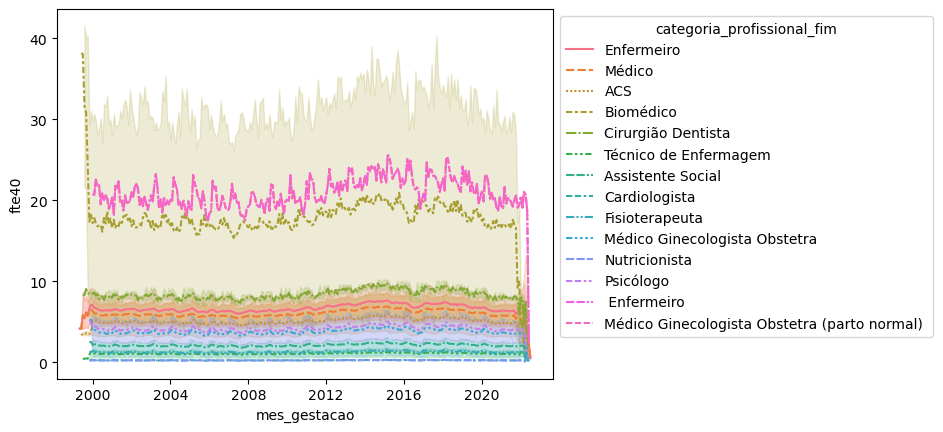

In [68]:
# tomando um regiao como referência 

df_11001 = df_tempo_prof[(df_tempo_prof.regiao =='52001')]

ax = sns.lineplot(x = "mes_gestacao", y = "fte40", data=df_11001, hue = 'categoria_profissional_fim',
              style="categoria_profissional_fim")

#x_dates = df_11001['mes_gestacao'].dt.strftime('%Y-%m-%d').sort_values().unique()

#ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()


In [ ]:
# salvando para jogar no pbi 

# df_tempo_prof.to_csv('df_completoPBI_v2.csv')